In [399]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance
import xgboost
from alibi.explainers import ALE
from alibi.explainers import plot_ale

In [426]:
df=pd.read_excel('RES_DATA.xlsx')
df=df.drop(columns=['Unnamed: 0', 'name'])
df['npxg'] = df['npxg'].str.extract(r'^([0-9.,]+)')
df['npxg'] = df['npxg'].str.replace(',', '.').astype(float)
df

,Club,national,season,age,appearances,minutes,goals_by_player,npxg,xg90,xa90,xgchain90,xgbuildup90,wins,goals_by_club,season_place,Price in €
0,Bayern Monachium,Francja,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45000000.0
1,Bayern Monachium,Holandia,23/24,21,1.0,6.0,0.0,0.00,0.40,0.00,8.91,6.05,23.0,94.0,3.0,30000000.0
2,Bayern Monachium,Francja,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40000000.0
3,Bayern Monachium,Senegal,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000000.0
4,Bayern Monachium,Austria,23/24,29,25.0,1971.0,4.0,3.61,10.24,0.13,0.69,0.47,18.0,68.0,3.0,20000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,NaN,Niemcy,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300000.0
2252,St. Pauli,Brazylia,24/25,30,1.0,1.0,0.0,0.00,0.00,0.00,0.00,0.00,8.0,28.0,14.0,300000.0
2253,NaN,Niemcy,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300000.0
2254,NaN,Maroko,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300000.0


## Shapes and info about data

In [427]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Club             2003 non-null   object 
 1   national         2256 non-null   object 
 2   season           1065 non-null   object 
 3   age              2256 non-null   int64  
 4   appearances      1065 non-null   float64
 5   minutes          1065 non-null   float64
 6   goals_by_player  1065 non-null   float64
 7   npxg             1065 non-null   float64
 8   xg90             1065 non-null   float64
 9   xa90             1065 non-null   float64
 10  xgchain90        1065 non-null   float64
 11  xgbuildup90      1065 non-null   float64
 12  wins             1065 non-null   float64
 13  goals_by_club    1065 non-null   float64
 14  season_place     1065 non-null   float64
 15  Price in €       2251 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 282.1+ KB


In [428]:
print(df.shape)

(2256, 16)


#### Check % of Nan values in all columns

In [429]:
print(df.isna().sum()/len(df)*100)

Club               11.214539
national            0.000000
season             52.792553
age                 0.000000
appearances        52.792553
minutes            52.792553
goals_by_player    52.792553
npxg               52.792553
xg90               52.792553
xa90               52.792553
xgchain90          52.792553
xgbuildup90        52.792553
wins               52.792553
goals_by_club      52.792553
season_place       52.792553
Price in €          0.221631
dtype: float64


## Duplicates

In [430]:
#Drop all duplicates
#I ve got 61 duplicates
print(df.duplicated().sum())



61


In [431]:
df=df.drop_duplicates()

## Nan values

### As we can see majority of nan values are in strategiest columns with the most important data from whole BundesLiga's matches, so I decided to drop them all.

In [432]:
print(df.isna().sum())

Club                240
national              0
season             1130
age                   0
appearances        1130
minutes            1130
goals_by_player    1130
npxg               1130
xg90               1130
xa90               1130
xgchain90          1130
xgbuildup90        1130
wins               1130
goals_by_club      1130
season_place       1130
Price in €            5
dtype: int64


In [433]:
df=df.dropna().reset_index().drop(columns=['index', 'national', 'xa90','xgbuildup90', ]) #wywalenie nacji znacznie polepszyło model z 0.52 do 6.4 dla R^2
print(f'Mean of Price: {df['Price in €'].mean()}')
print(f'STD of Price: {df['Price in €'].std()}')

Mean of Price: 9628028.169014085
STD of Price: 13940877.47300187


C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\4111936184.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='Price in €', palette='Set1')


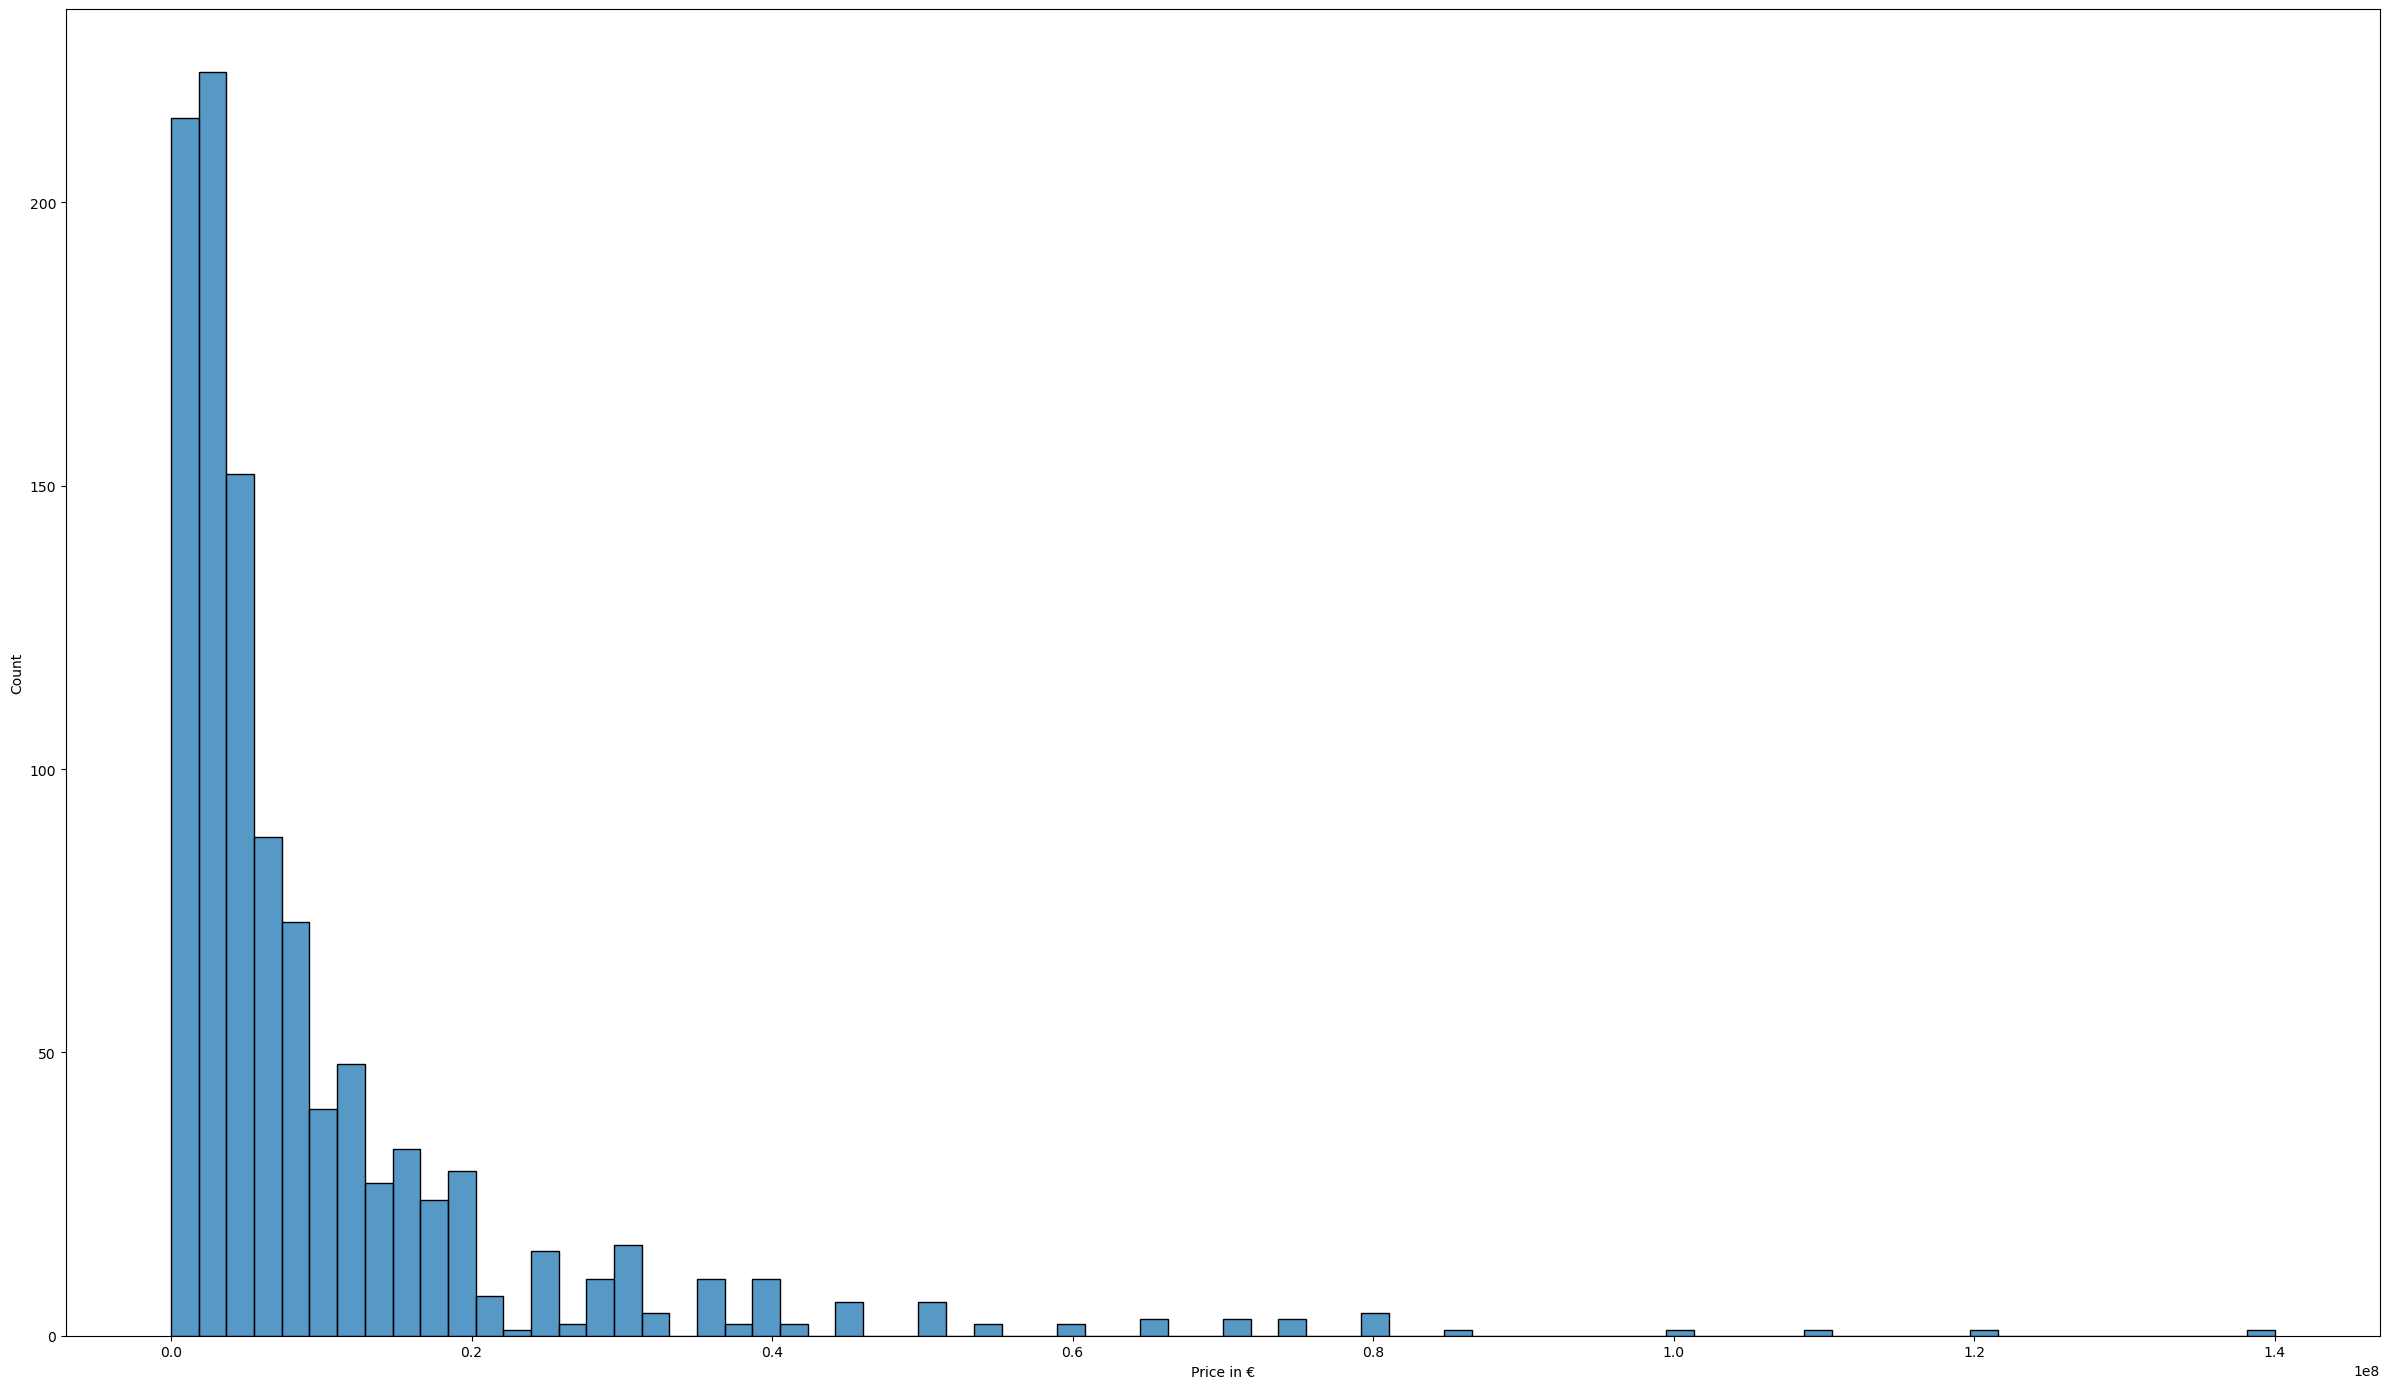

In [393]:
fig, ax = plt.subplots(figsize=(24, 14))

sns.histplot(data=df, x='Price in €', palette='Set1')
    
plt.tight_layout()
plt.show()

In [369]:
from scipy.stats import lognorm, kstest
params=lognorm.fit(df['Price in €'])
D,p=kstest(df['Price in €'], 'lognorm', args=params)
print(f"Stat D: {D:.4f}, p-value: {p:.4f}")

Stat D: 0.0388, p-value: 0.0784


c:\Users\kamil\anaconda3\envs\A1\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


I got p-value > 0.05, so there are no grounds for reject my hypothesis about lognorm Price distribution

## Distribution of numeric data

In [370]:
cols=['age', 'Price in €', 'appearances',
       'minutes', 'goals_by_player', 'npxg', 'xg90', 'xa90', 'xgchain90',
       'xgbuildup90', 'wins', 'goals_by_club', 'season_place']
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(24, 14))
ax = ax.flatten()
for i, col in enumerate(cols):
    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col, palette='Set1', ax=ax[i])
    else:
        sns.histplot(data=df, x=col, palette='Set1', bins=10, ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('count')
plt.tight_layout()
plt.show()

C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\366551718.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, palette='Set1', bins=10, ax=ax[i])
C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\366551718.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, palette='Set1', bins=10, ax=ax[i])
C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\366551718.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, palette='Set1', bins=10, ax=ax[i])
C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\366551718.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x=col, palette='Set1', bins=10, ax=ax[i])
C:\Users\kamil\AppData\Local\Temp\ipykernel_27860\366551718.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(d

KeyError: 'xa90'

## HeatMap

In [ ]:
df_filtered = df[cols]

df_numeric = df_filtered.select_dtypes(include=['float64', 'int64'])

corr = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("HeatMap with numeric values")
plt.show()

KeyError: "['xa90', 'xgbuildup90'] not in index"

# MODEL


In [371]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error



In [434]:
club=df['Club'].unique()
season=df['season'].unique()
map_club={}
map_season={}
for club,i in enumerate(club):
    map_club[i]=club
for season,i in enumerate(season):
    map_season[i]=season
    
df['Club']=df['Club'].map(map_club)
df['season']=df['season'].map(map_season)

In [435]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [437]:
sc = StandardScaler()
# X_train = X_train.toarray()
# X_test = X_test.toarray()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# lower_bound_train = np.percentile(y_train, 2.5)
# upper_bound_train = np.percentile(y_train, 97.5)
# mask_train = (y_train >= lower_bound_train) & (y_train <= upper_bound_train)
# X_train = X_train[mask_train]
# y_train = y_train[mask_train]

# lower_bound_test = np.percentile(y_test, 2.5)
# upper_bound_test = np.percentile(y_test, 97.5)
# mask_test = (y_test >= lower_bound_test) & (y_test <= upper_bound_test)
# X_test = X_test[mask_test]
# y_test = y_test[mask_test]


## Random Forest

In [383]:
rf = RandomForestRegressor(random_state=0)

param_grid = {
    'n_estimators': [50, 100,150],       
    'max_depth': [None, 10, 20, 30,50],      
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],        
    'bootstrap': [True, False],           
    'criterion': ['squared_error', 'absolute_error']     
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,         # cross validation
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,    
                           verbose=2)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
grid_search.fit(X_train, y_train_log)

best_model = grid_search.best_estimator_
print("Najlepsze parametry:", grid_search.best_params_)

y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Najlepsze parametry: {'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
MSE: 135240322499920.0781
MAE: 5190839.9048
R^2: 0.5175


## SVR

In [ ]:
svr = SVR()

param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 1, 5]
}

grid_search = GridSearchCV(estimator=svr,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Najlepsze parametry:", grid_search.best_params_)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test,y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f'MAPE: {mape:.2f}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Najlepsze parametry: {'C': 100, 'epsilon': 5, 'gamma': 'scale', 'kernel': 'linear'}
MSE: 304515386145221.19
MAE: 7998686.51
R²: -0.0864


## XGBoost

In [440]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=0)

param_grid = {
    'n_estimators': [50, 100, 200,250],
    'max_depth': [2,3, 6,5,7, 10],
    'learning_rate': [0.01,0.08, 0.1,0.11,0.12],
    'subsample': [0.6,0.5,0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=3,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Najlepsze parametry:", grid_search.best_params_)

y_pred = best_model.predict(X_test)


#mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
#mape=mean_absolute_percentage_error(y_test,y_pred)

#print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
#print(f'MAPE: {mape:.2f}')

#waznosc predyktorów
#PDP, ICE 
#ALE
#EX AI

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Najlepsze parametry: {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
MAE: 5108911.85
R²: 0.6776


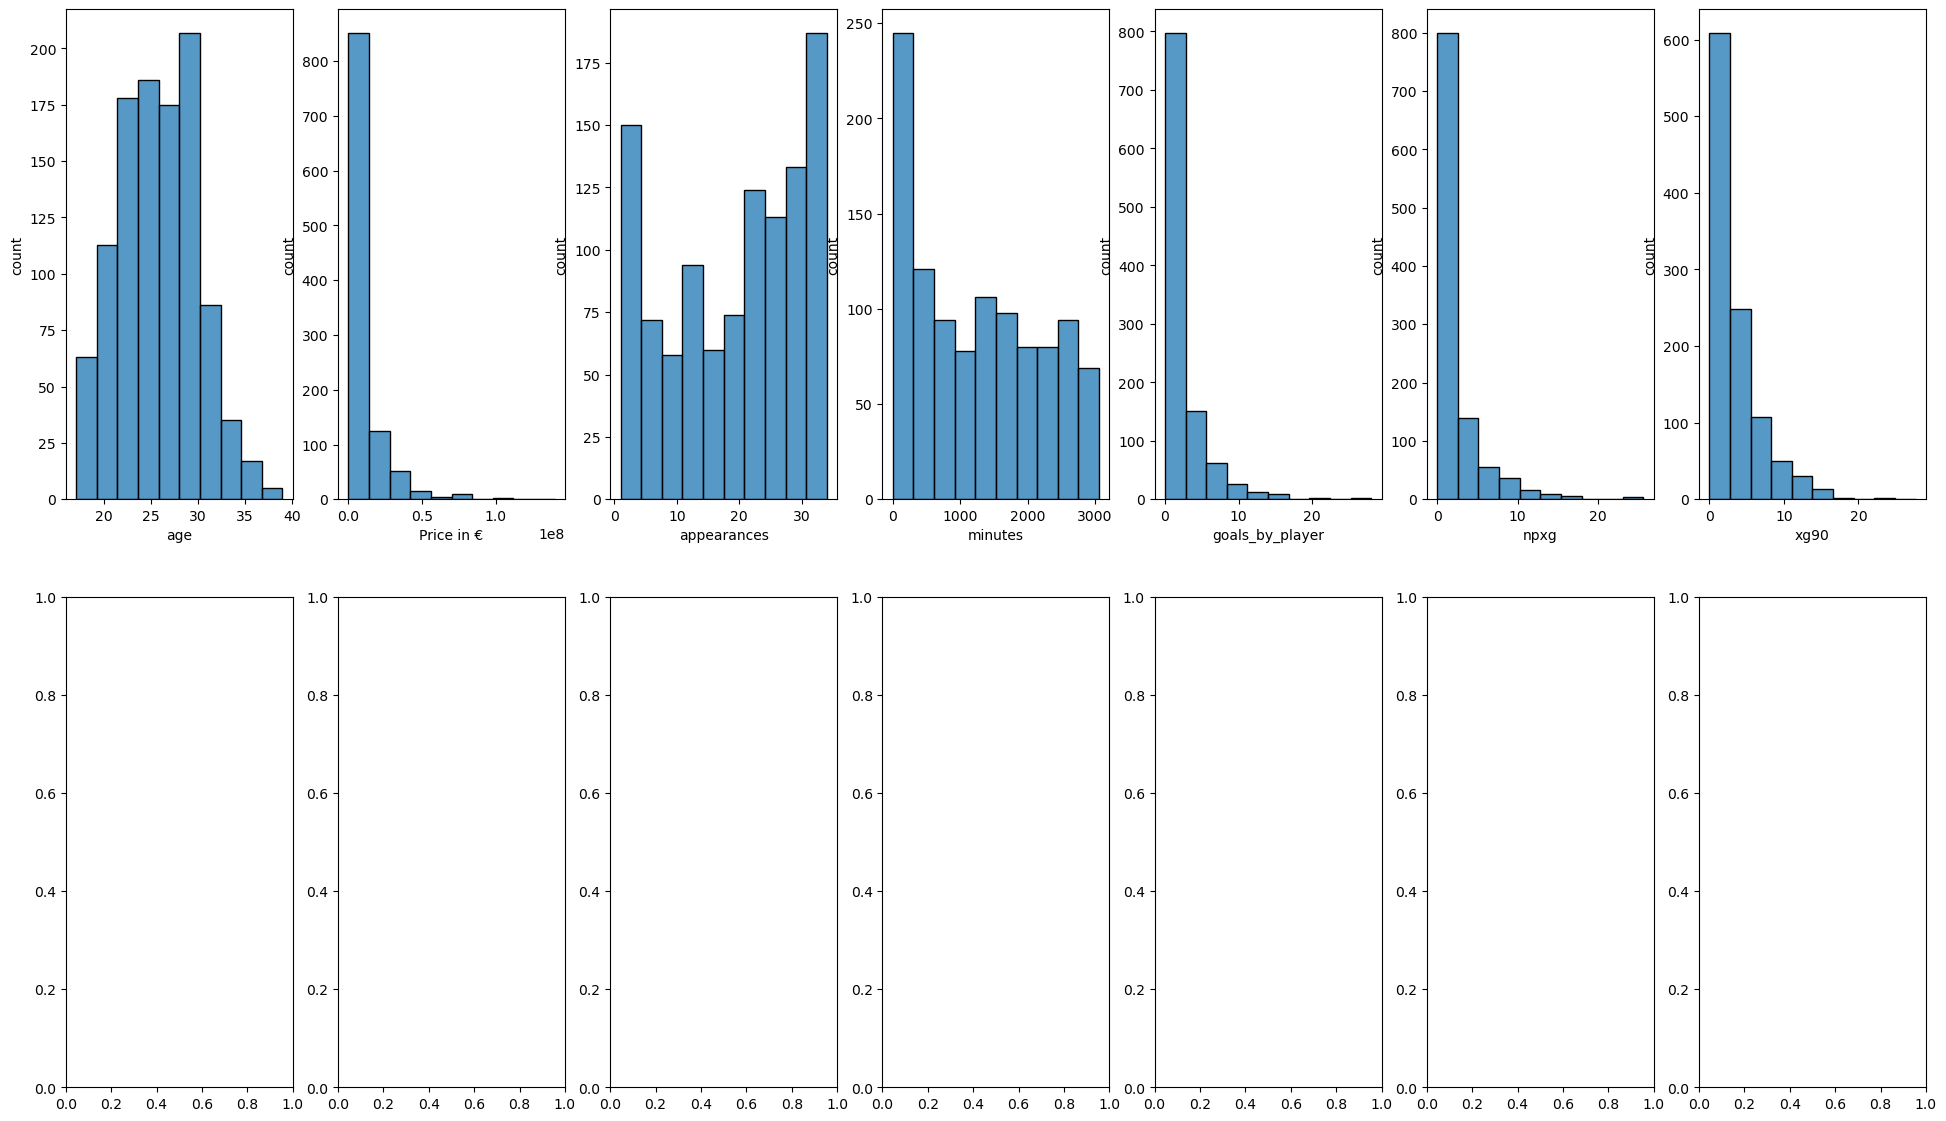

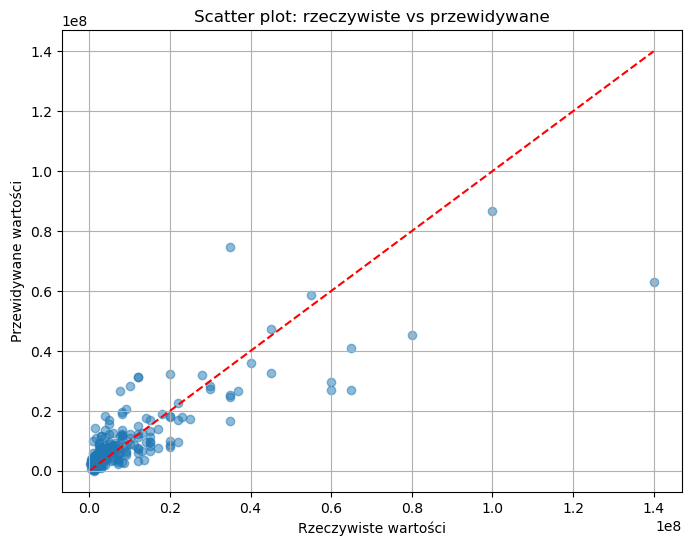

In [377]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linia idealnej predykcji
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Scatter plot: rzeczywiste vs przewidywane')
plt.grid(True)
plt.show()


## FEATURE IMPORTANCE

In [ ]:
print(best_model.feature_importances_)

[0.07792155 0.04630458 0.06698235 0.02557505 0.05870983 0.07041843
 0.09847273 0.18822117 0.04690817 0.06182541 0.02590129 0.06461673
 0.10165823 0.06648436]


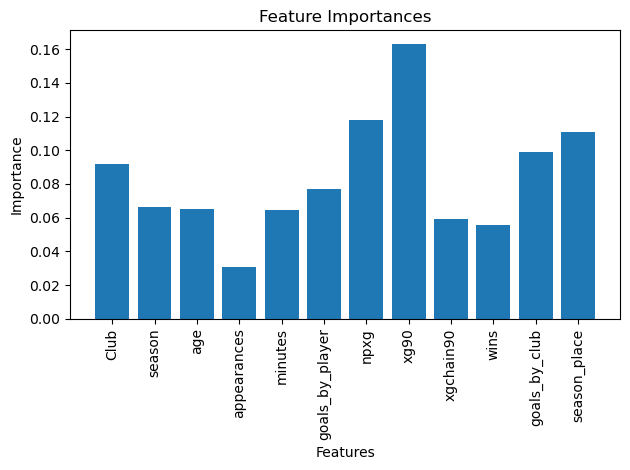

In [378]:
features=list(df.columns[:-1])
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.xticks(range(len(features)), features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()  
plt.show()


## PERMUTATION IMPORTANCE

In [379]:
print(f'R2 before feature permutation: {r2}')
result = permutation_importance(best_model, X_test, y_test, scoring='r2', n_repeats=20, random_state=42)
result = result.importances_mean
result=dict(zip(features,result))
print(pd.Series(result).sort_values(ascending=False))

R2 before feature permutation: 0.6775678726259615
npxg               0.160183
xg90               0.151685
age                0.127600
Club               0.114145
goals_by_player    0.092624
goals_by_club      0.075933
minutes            0.038678
season             0.015891
appearances        0.014338
wins               0.008207
xgchain90          0.005142
season_place      -0.002812
dtype: float64


## SHAP

In [380]:
explainer=shap.TreeExplainer(best_model)
shap_values=explainer.shap_values(X_test)
waterfall_explainer=shap.Explainer(best_model, X_test)
waterfall_values=waterfall_explainer(X_test)
waterfall_values.feature_names=features

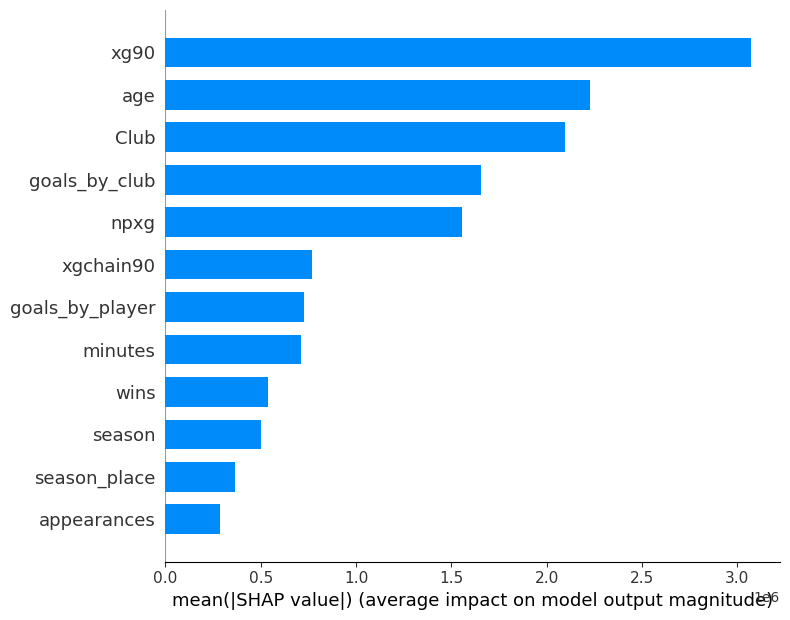

In [381]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features)

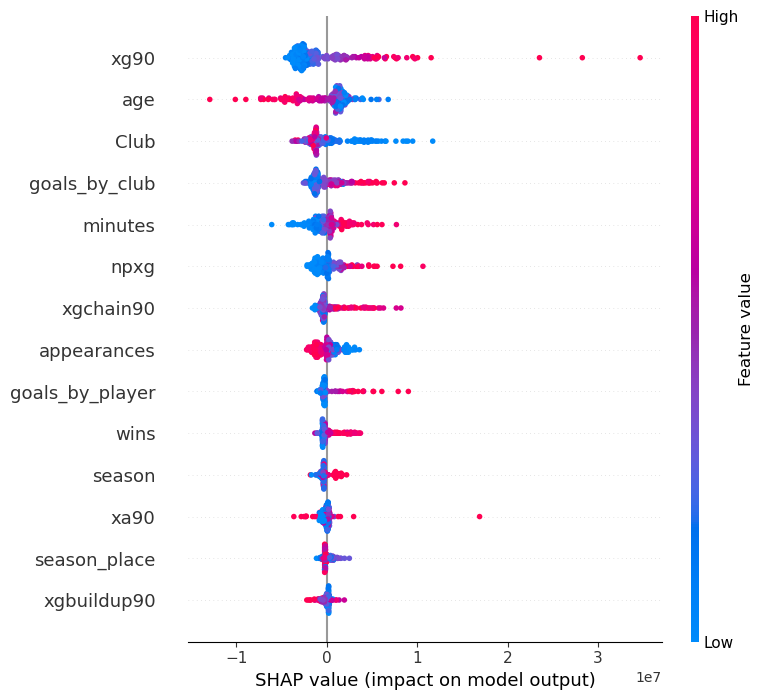

In [213]:
shap.summary_plot(shap_values, X_test, feature_names=features)

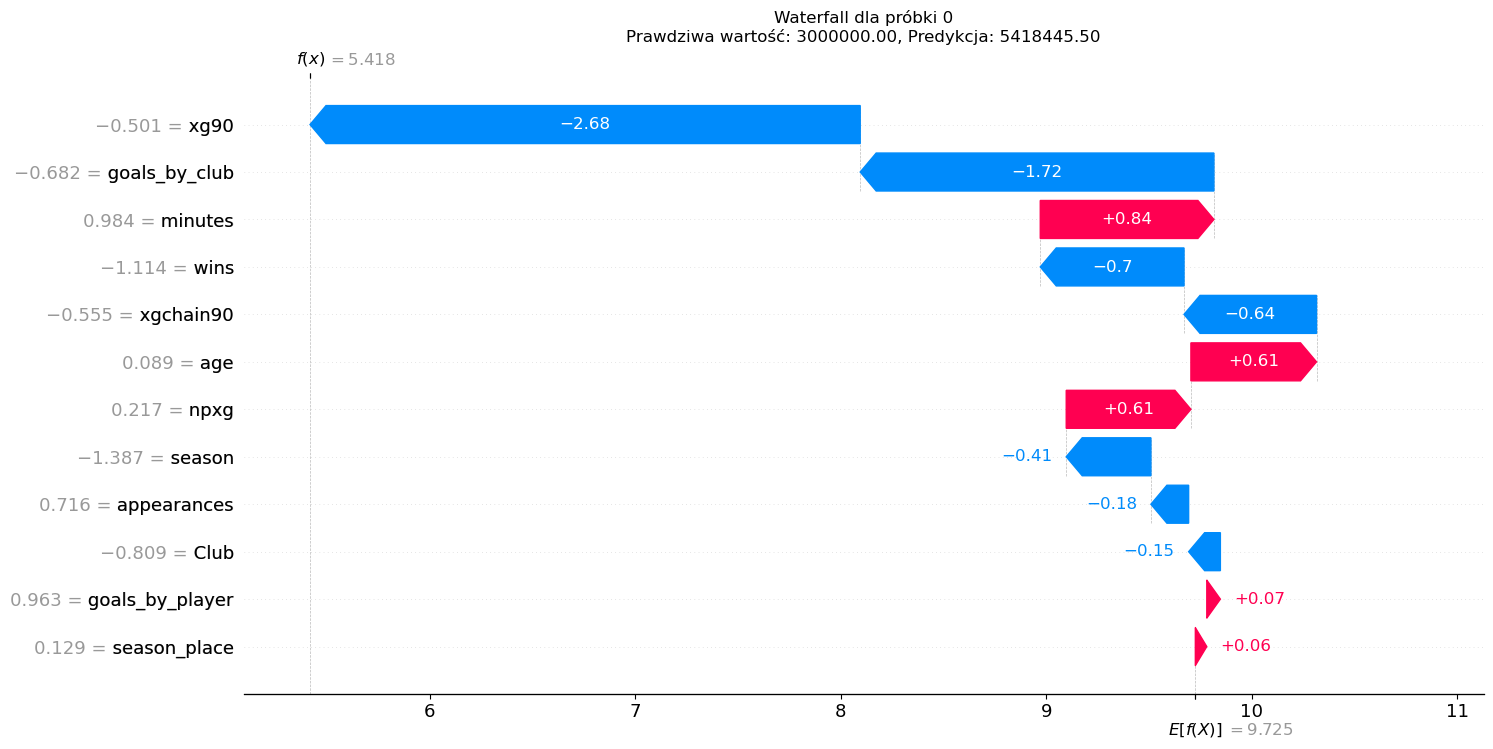

In [382]:
sv = waterfall_values[5]
sv_scaled = shap.Explanation(
    values = sv.values / 1_000_000,
    base_values = sv.base_values / 1_000_000,
    data = sv.data,
    feature_names = sv.feature_names
)
shap.plots.waterfall(sv_scaled, max_display=len(features), show=False)
fig = plt.gcf()
fig.set_size_inches(16, 8)
pred_value = best_model.predict(X_test[[5]])[0]  
plt.title(f"Waterfall dla próbki 0\nPrawdziwa wartość: {y_test[5]:.2f}, Predykcja: {pred_value:.2f}")

plt.show()

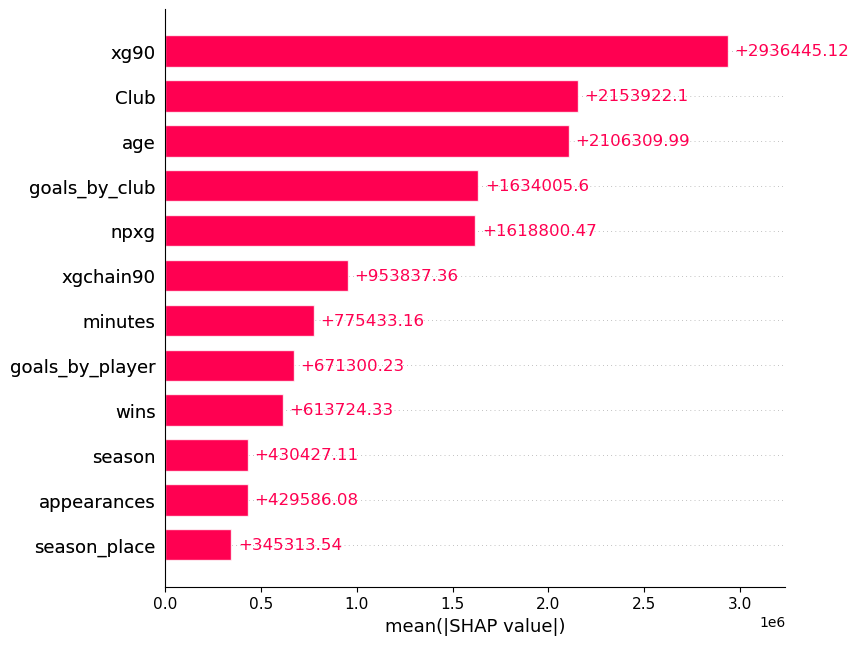

In [383]:
shap.plots.bar(waterfall_values, max_display=len(features))


## PDP, ICE, ALE

In [384]:
ale=ALE(best_model.predict, feature_names=features, target_names=['Price in €'])
exp=ale.explain(X)

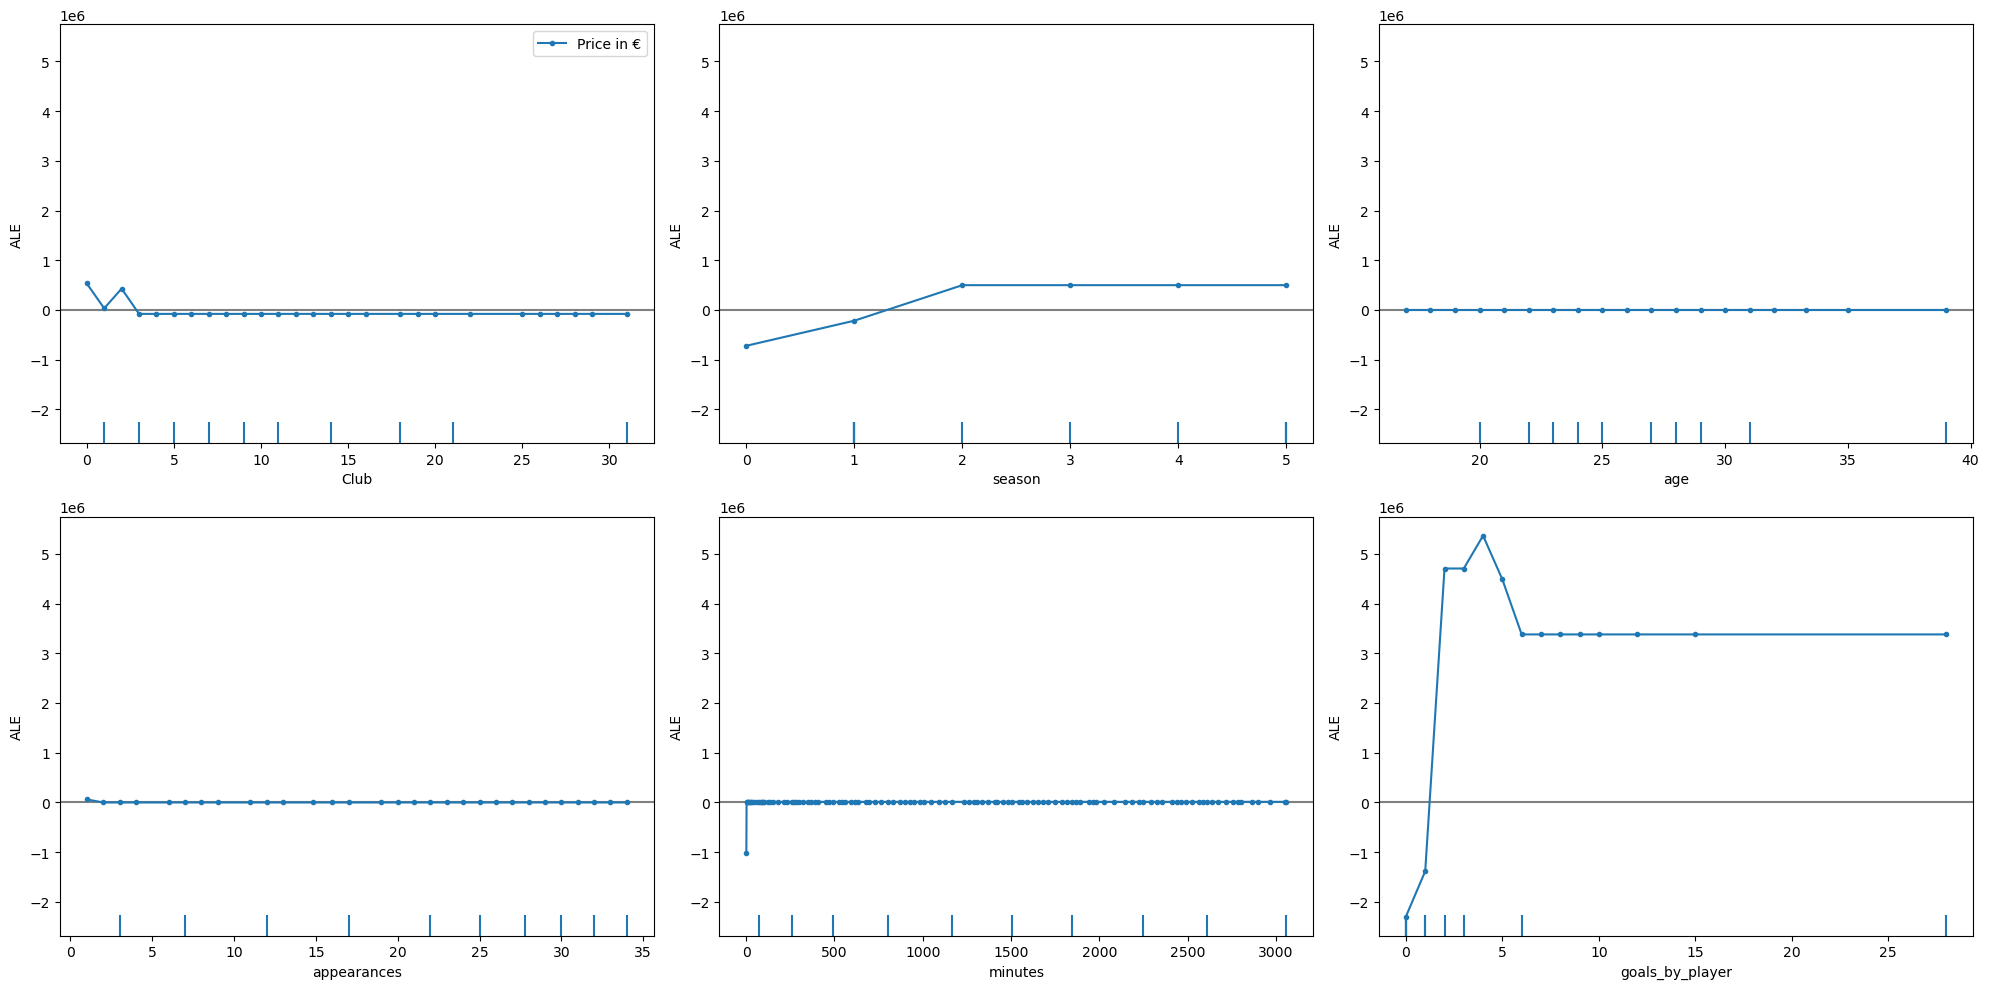

In [ ]:
plot_ale(exp, features=[0,1,2,3,4,5,6], fig_kw={'figwidth':20,'figheight':10})
plt.show()

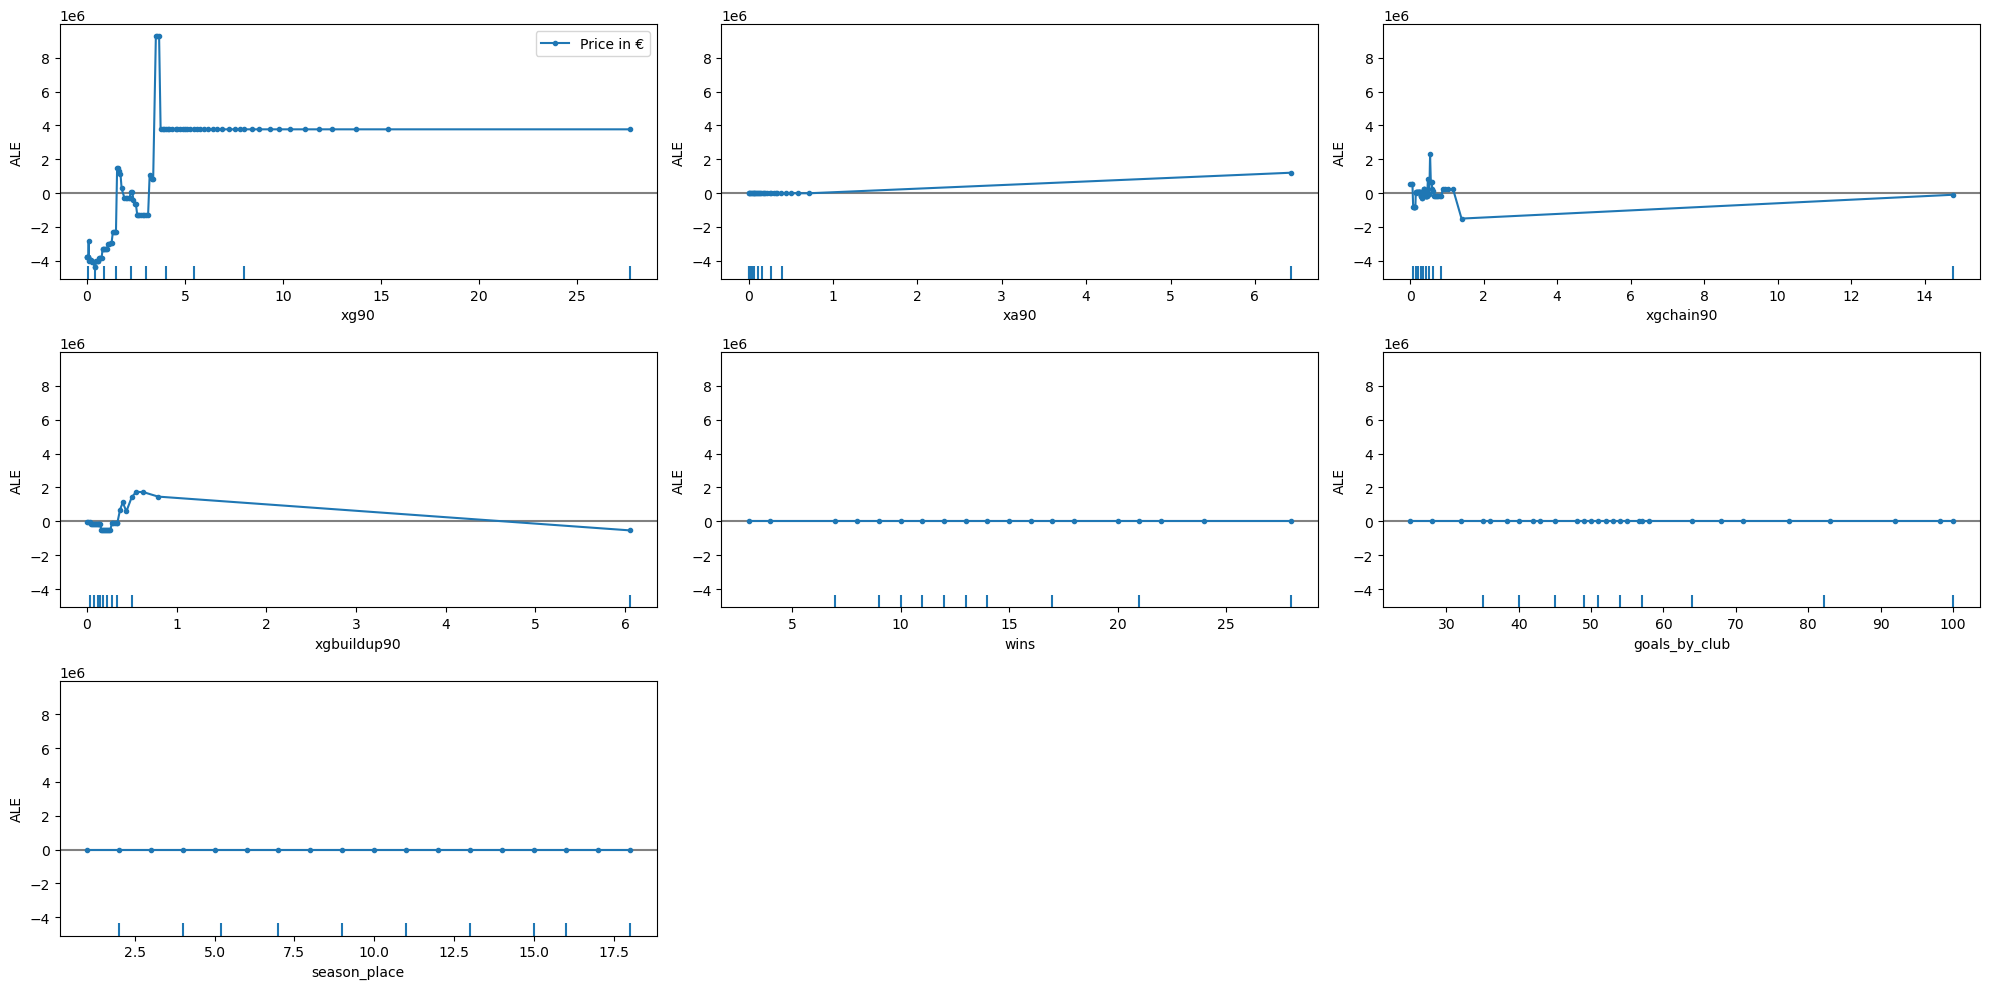

In [308]:
plot_ale(exp, features=[7,8,9,10,11,12,13], fig_kw={'figwidth':20,'figheight':10})
plt.show()